In [1]:
import gzip
!pip install idx2numpy
import idx2numpy
import numpy as np
from google.colab.patches import cv2_imshow, cv2
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7918 sha256=ce8a0a5a77d335ba495dbaae20625ab8b9fc65899f9d840cce56dc4c5d192a0d
  Stored in directory: /root/.cache/pip/wheels/34/61/53/a6a64db5e907bdf792f401b5bfb922eabfe6686d08692167f3
Successfully built idx2numpy


#Question 1

In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



--2023-04-27 05:34:17--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-04-27 05:34:17 (86.0 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-04-27 05:34:17--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===========

In [3]:
!gzip -d train-images-idx3-ubyte.gz

!gzip -d train-labels-idx1-ubyte.gz

!gzip -d t10k-images-idx3-ubyte.gz

!gzip -d t10k-labels-idx1-ubyte.gz

# New Section

In [4]:
train_images_file = 'train-images-idx3-ubyte'
train_lable_file = 'train-labels-idx1-ubyte'
test_images_file = 't10k-images-idx3-ubyte'
test_lable_file = 't10k-labels-idx1-ubyte'

X_train = idx2numpy.convert_from_file(train_images_file)
y_train = idx2numpy.convert_from_file(train_lable_file)
X_test = idx2numpy.convert_from_file(test_images_file)
y_test = idx2numpy.convert_from_file(test_lable_file)


In [19]:
cv2_imshow(X_train[0])
print(y_train.shape)
print(X_train.shape)

train_input = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
test_input = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
print(train_input.shape)
print(type(train_input[0]))
print(test_input.shape)

(60000,)
(60000, 28, 28)
(60000, 784)
<class 'numpy.ndarray'>
(10000, 784)


In [6]:
def oneHotEncoding(y):
  y_unique = set(y)
  unique = len(y_unique)
  y_encoded = [[0 for _ in range(unique)] for _ in range(len(y))]

  for i in range(len(y)):
      y_encoded[i][y[i]] = 1
      
  return np.array(y_encoded)

In [7]:
print(y_train)
y_train_encoded = oneHotEncoding(y_train)
print((np.argmax(y_train_encoded, axis =1) - y_train).all())
y_test_encoded = oneHotEncoding(y_test)
print(y_test_encoded.shape)

[5 0 4 ... 5 6 8]
False
(10000, 10)


#Question 2 and Question 3

In [8]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
class Linear_classifier:
  
  def __init__(self, numClasses):
    self.w = None
    self.numClasses = numClasses
    np.random.seed(42)
    
  def model(self, x):
    #x = batch_size X numFeatures, w = numClasses X numFeatures
    #print(x.shape, self.w.shape) 
    a = np.matmul(self.w, x.T).T
    return np.exp(a - np.max(a))/np.exp(a - np.max(a)).sum()

    
  def predict(self, X):
    
    result = self.model(X)
    return np.argmax(result, axis = 1)

  def data_mini_batches(self, X, y, batch_size):
    mini_batches = []
    data = np.concatenate((X, y), axis = 1)
    #np.random.seed(10)
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
  
    for i in range(n_minibatches):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        mini_batches.append(mini_batch)
    if data.shape[0] % batch_size != 0:
        rem_mini_batch = data[(i + 1) * batch_size:, :]
        mini_batches.append(rem_mini_batch)
    return np.array(mini_batches)
  
  def loss(self, X, y, W):
    
    a = -np.matmul(X, W.T)
    b = X.shape[0]
    loss = (1/b) * (np.trace(np.matmul(X, W.T, y) + np.sum(np.log(np.sum(np.exp(a), axis=1)))))
    return loss
  
  def fit(self, X, Y, epochs = 1, lr = 1, batch_size = 1, l2 = 0.1):
    
    self.w = np.zeros((Y.shape[1],X.shape[1]))
    #print(self.w.shape)
    accuracy = []
    max_accuracy = 0
    chkptw = None

    loss_list = []

    for i in range(epochs):
      SGD_mini_batches = self.data_mini_batches(X, Y, batch_size)
      loss_add = 0
      for m in SGD_mini_batches:
        x = m[:, :-self.numClasses]
        y = m[:, -self.numClasses:]
        y_pred = self.model(x)
        y_pred = y_pred > 0.6
        #self.w = numClasses X numFeatures, y-y_pred = batch_size X numClasses, x = batch_size X numFeatures
        self.w = self.w + ((lr/batch_size) * np.matmul((y - y_pred).T, x)) - (2 * l2 * self.w)
        loss_add += self.loss(x, y, self.w)
      loss_list.append(loss_add / len(SGD_mini_batches))

      stepAccuracy = accuracy_score(self.predict(test_input/255.), np.argmax(y_test_encoded, axis = 1))
      accuracy.append(stepAccuracy)
      if(stepAccuracy > max_accuracy):
        max_accuracy = stepAccuracy
        chkptw = self.w

    self.w = chkptw
    print("Maximum Accuracy", max_accuracy)
    plt.plot(accuracy, label = "Accuracy")
    plt.plot(loss_list, label = "Loss")
    plt.legend()
    plt.show()

Batch_size = 1

Learning rate = 0.0001

Maximum Accuracy 0.7308


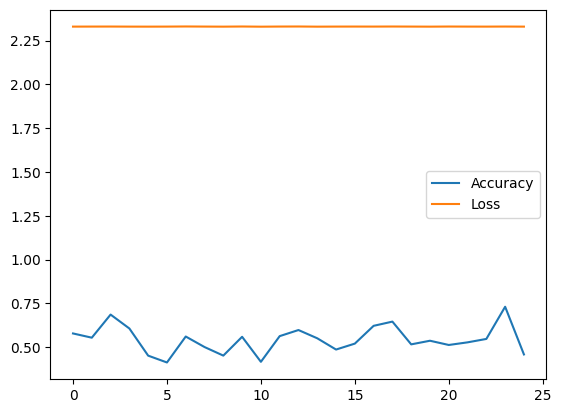

Time taken for training: 243.07224345207214


In [9]:
import time
linear_class_1 = Linear_classifier(numClasses = y_train_encoded.shape[1])
s = time.time()
linear_class_1.fit(train_input/255., y_train_encoded, epochs = 25, lr = 0.0001, batch_size = 1, l2 = 0.001)
e = time.time()
print("Time taken for training:", e-s)

Batch_size = 10

Learning rate = 0.0005

Maximum Accuracy 0.7308


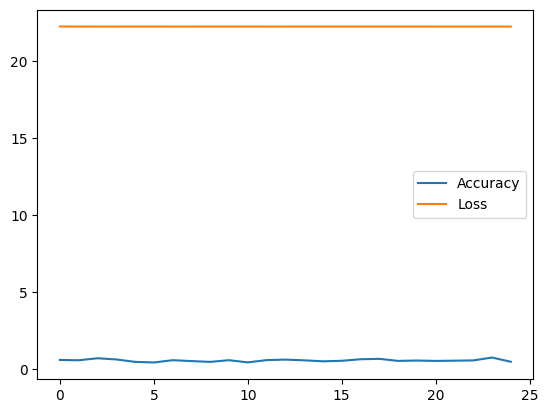

Time taken to train: 55.73460078239441


In [10]:
linear_class_10 = Linear_classifier(numClasses = y_train_encoded.shape[1])
s = time.time()
linear_class_10.fit(train_input/255., y_train_encoded, epochs = 25, lr = 0.0005, batch_size = 10, l2 = 0.01)
e = time.time()
print("Time taken to train:", e-s)

Batch_size = 100

Learning rate = 0.001

Maximum Accuracy 0.733


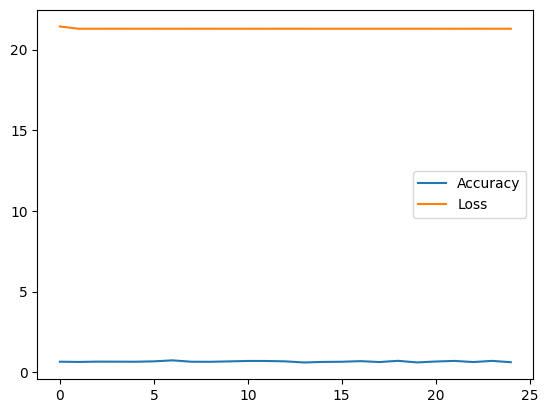

Time taken to train: 39.01604866981506


In [11]:
linear_class_100 = Linear_classifier(numClasses = y_train_encoded.shape[1])
s = time.time()
linear_class_100.fit(train_input/255., y_train_encoded, epochs = 25, lr = 0.001, batch_size = 100, l2 = 0.01)
e = time.time()
print("Time taken to train:", e-s)

Batch_size = 1000

Learning rate = 0.03



Maximum Accuracy 0.7384


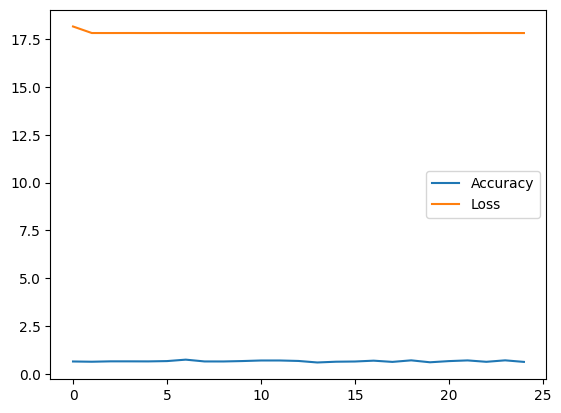

Time taken to train: 39.34797286987305


In [12]:
linear_class_1000 = Linear_classifier(numClasses = y_train_encoded.shape[1])
s = time.time()
linear_class_1000.fit(train_input/255., y_train_encoded, epochs = 25, lr = 0.03, batch_size = 1000, l2 = 0.1)
e = time.time()
print("Time taken to train:", e-s)

In [13]:
cv2_imshow(X_test[10])
cv2_imshow(X_test[11])
cv2_imshow(X_test[12])
cv2_imshow(X_test[13])
cv2_imshow(X_test[14])
print(linear_class_1.predict(test_input[10:15]/255.))
print(linear_class_10.predict(test_input[10:15]/255.))
print(linear_class_100.predict(test_input[10:15]/255.))
print(linear_class_1000.predict(test_input[10:15]/255.))

[0 0 9 0 1]
[0 0 9 0 1]
[0 0 9 0 1]
[0 0 9 0 1]


#Question 5

Maximum Accuracy 0.243


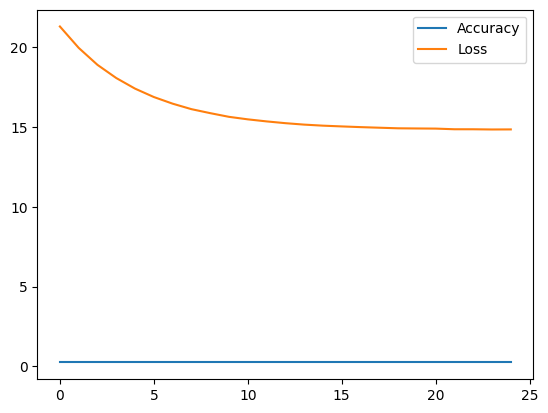

Maximum Accuracy 0.505


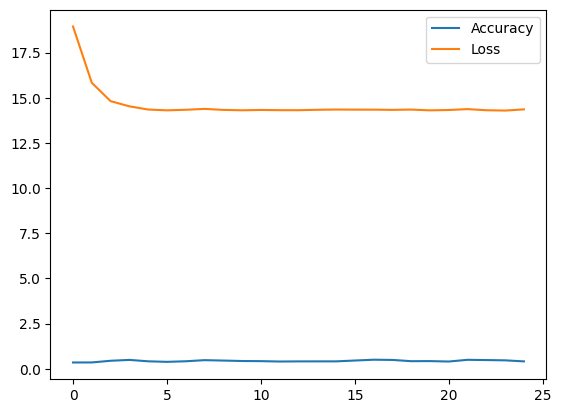

Maximum Accuracy 0.6056


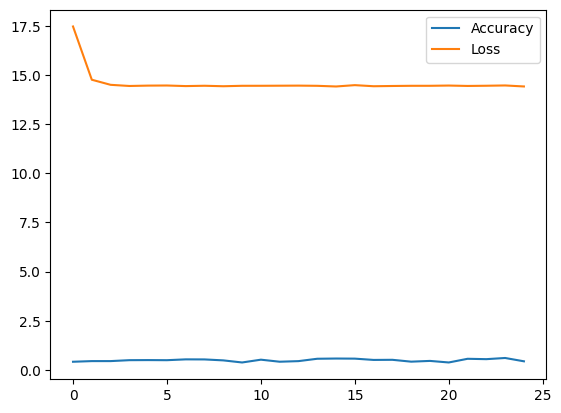

Maximum Accuracy 0.6522


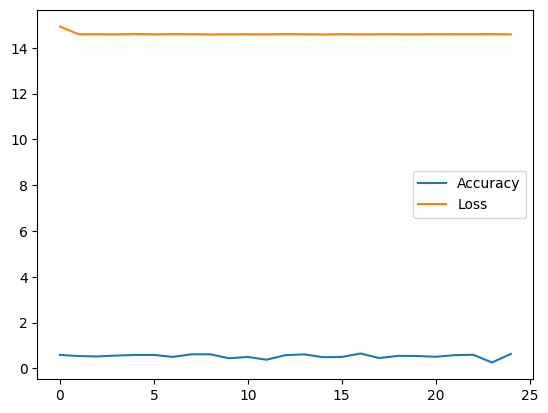

In [14]:
n_prime = [100, 500, 1000, 10000]
train_input_copy = np.concatenate((train_input/255., y_train_encoded), axis = 1)
np.random.seed(42)
for n in n_prime:
  np.random.shuffle(train_input_copy)
  train_input_subset = train_input_copy[0:n, :-y_train_encoded.shape[1]]
  train_label_subset = train_input_copy[0:n, -y_train_encoded.shape[1]:]
  linear_classifier = Linear_classifier(y_train_encoded.shape[1])
  linear_classifier.fit(train_input_subset, train_label_subset, epochs = 25, lr = 0.05, batch_size = 100, l2 = 0.1)
  train_input_copy = train_input_copy[n:, :]

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=50, tol=0.1)
clf.fit(train_input/255., y_train)
sklearnAccuracy = accuracy_score(clf.predict(test_input/255.), np.argmax(y_test_encoded, axis = 1))
print("Accuracy", sklearnAccuracy)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(test_input, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity without penalty: %.2f%%" % sparsity)
print("Test score without penalty: %.4f" % score)
print(clf.predict(test_input[10:15]/255.))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy 0.9215
Sparsity without penalty: 8.55%
Test score without penalty: 0.8605
[0 6 9 0 1]


Time taken for Tensorflow Training: 113.33137392997742
313/313 [==============================] - 0s 1ms/step
0.6806


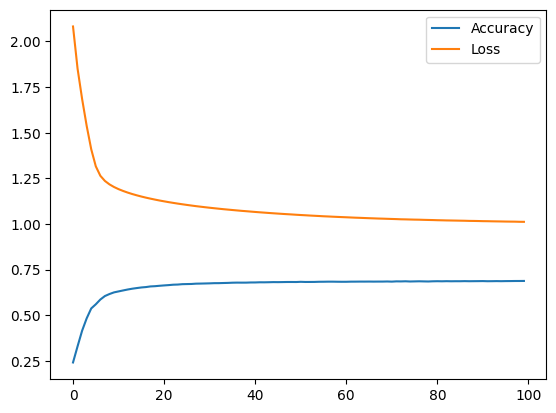

In [23]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import SGD
import tensorflow as tf
import keras

classifier = Sequential()
classifier.add(Dense(2, input_dim=784, activation='linear', kernel_initializer = 'zeros', kernel_regularizer=keras.regularizers.l2(0.01),  name='layer1'))
classifier.add(Dense(10, activation = 'softmax'))
optimizer = SGD(learning_rate=0.005)
classifier.compile(loss = tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
start = time.time()
h = classifier.fit(train_input/255., y_train_encoded, epochs=100, batch_size=100, verbose = False)
end = time.time()
print("Time taken for Tensorflow Training:", (end - start))
print(accuracy_score(np.argmax(classifier.predict(test_input/255.), axis = 1), np.argmax(y_test_encoded, axis =1)))
plt.plot(h.history['accuracy'], label = 'Accuracy')
plt.plot(h.history['loss'], label = 'Loss')
plt.legend()
plt.show()